# Autocorrelation Diagnostic

Autocorrelation plots show the degree a time series signal is correlated with itself.  As a diagnostic for Markov Monte Carlo Chains they provides an estimate the indepedence of each draw from previous draws in the same chain. This is important since draws from a mcmc chain that are highly correlated could indicate issues with chain convergence.

## Arviz Autocorrelation plots
By default ArviZ will generate an autocorrelation plot for each variable and for each chain. The autocorrelation should decrease as the lag increases, which indicates a low level of correlation.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1c18753080>,
      dtype=object)

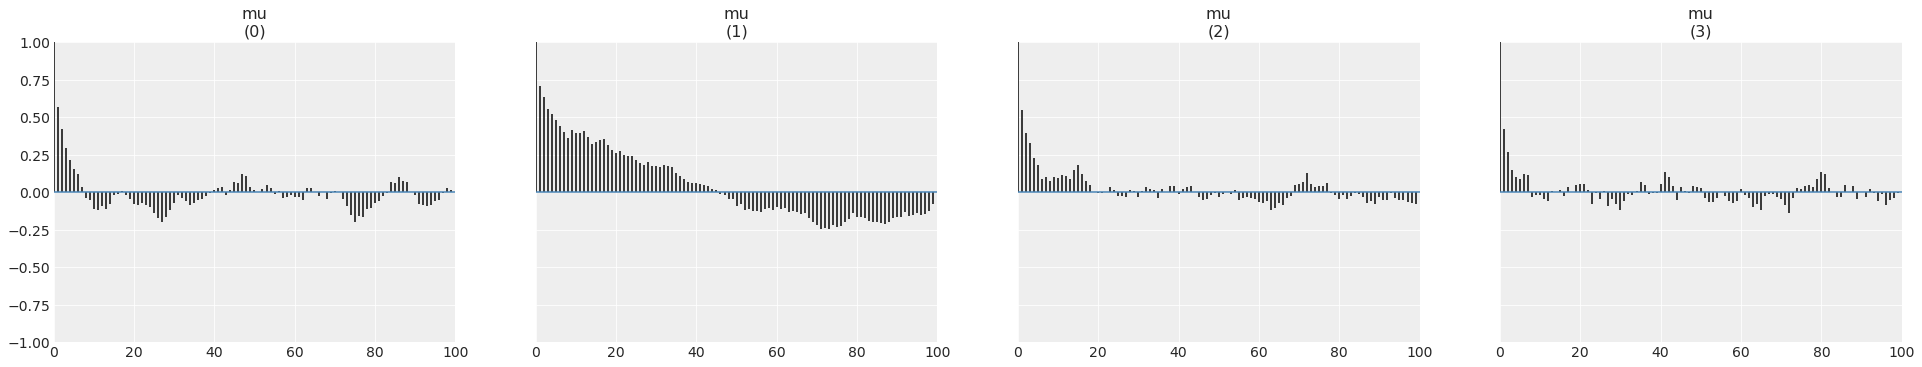

In [7]:
import arviz as az
import numpy as np
import matplotlib.pyplot as plt

az.style.use('arviz-darkgrid')
data = az.load_arviz_data('centered_eight')
az.plot_autocorr(data, var_names="mu")

## Autocorrelation deriviation
Autocorrelation at each lag is defined as

$$\large \rho_{lag} = \frac{\Sigma_{i}^{N-lag} (\theta_{i} - \overline{\theta})(\theta_{i + lag} - \overline{\theta})}
{\Sigma_{i}^{N}(\theta_{i} - \overline{\theta})}$$

This formula may be recognized as a special form of Pearson's correlation coefficient, where instead of measuring the correlation between two arbitrary sets, we are instead measuring the correlation of different time slices of the same chain.

We can manually calculate the autocorrelation using numpy

In [8]:
chain_0 = data.posterior.sel(chain=0)
mu_0 = chain_0["mu"]
lag = np.arange(0,100)
auto_corr = []

for shift in lag:
    # Or None is to handle the case of indexing at -0
    corr = np.corrcoef(mu_0[:-shift or None],mu_0[shift:])[0,1]
    auto_corr.append(corr)
    
auto_corr[:5]

[1.0,
 0.5678988350930042,
 0.42329055833861234,
 0.2946733022467791,
 0.21681918780266368]

Text(0.5,0.98,'Autocorrelation of Mu Chain 0')

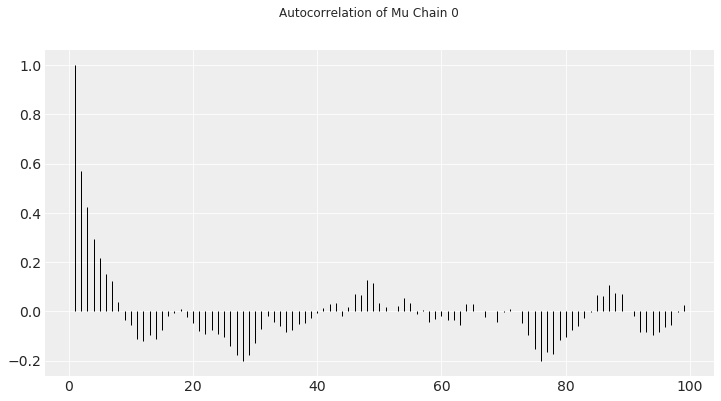

In [9]:
fig, ax = plt.subplots(figsize=(12,6))
ax.vlines(x=np.arange(1, 100),
                  ymin=0, ymax=auto_corr,
                  lw=1)
fig.suptitle("Autocorrelation of Mu Chain 0")

Text(0.5,1,'Autocorrelation of Mu Chain 0')

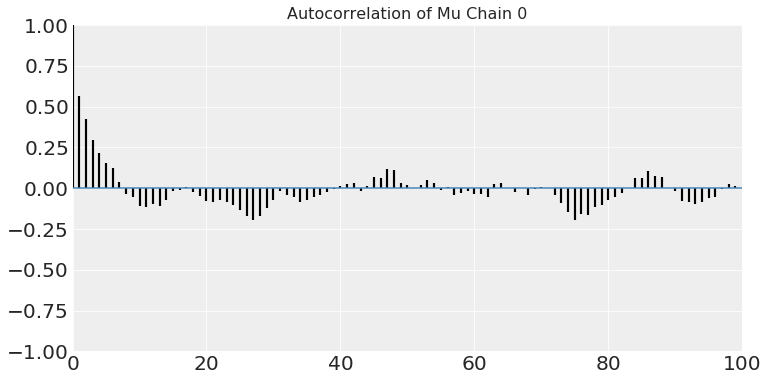

In [10]:
# Filter to just one chain
axes = az.plot_autocorr(chain_0, var_names="mu", figsize=(12,6))
axes[0][0].set_title("Autocorrelation of Mu Chain 0")

Note that this plot is identical to chain 0 for `mu` in the posterior data

## Additional examples

MCMC chains with high autocorrelation can indicate that a convergence to a stationary distribution. Take the following example where we try and use pymc3 estimate the parameters of a generated distribution.

In [11]:
import pymc3 as pm

# Generate observed distribution with fixed parameters
SD = 2
MU = -5
obs = np.random.normal(loc=MU, scale=SD, size=10000)

In [12]:
# Attempt to use pymc3 to estimate mean of the distribution
with pm.Model() as model:
    mu = pm.Normal("mu", mu=-5000, sd=1)
    y = pm.Normal("y", mu=mu, sd=SD, observed=obs)
    step = pm.Metropolis()
    trace = pm.sample(100, step, chains=2)


Only 100 samples in chain.
Multiprocess sampling (2 chains in 2 jobs)
Metropolis: [mu]
Sampling 2 chains: 100%|██████████| 1200/1200 [00:00<00:00, 2474.88draws/s]
The gelman-rubin statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The number of effective samples is smaller than 10% for some parameters.


In this example`Mu`is the free, or unknown, parameter that is being estimated by pymc3. The model is specified with a prior Normal prior with a mean of -5000, and only 100 steps are taken with a Metropolis Hasting sampler.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1c25bc5940>,
      dtype=object)

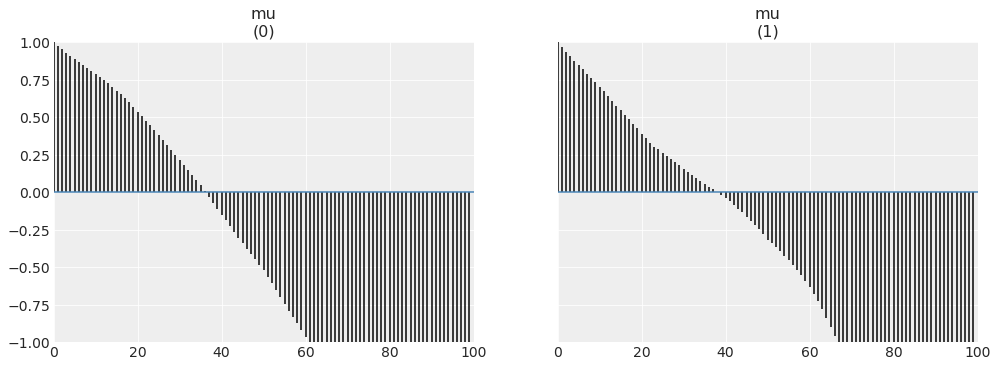

In [13]:
az.plot_autocorr(trace,max_lag=100)

When plotting the autocorrelation of the chains however a high degree of correlation is present, indicating that the sampling did not converge to a stationary distribution.

Multiprocess sampling (2 chains in 2 jobs)
Metropolis: [mu]
Sampling 2 chains: 100%|██████████| 11000/11000 [00:03<00:00, 2770.87draws/s]
The number of effective samples is smaller than 25% for some parameters.


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1c27e5e7b8>,
      dtype=object)

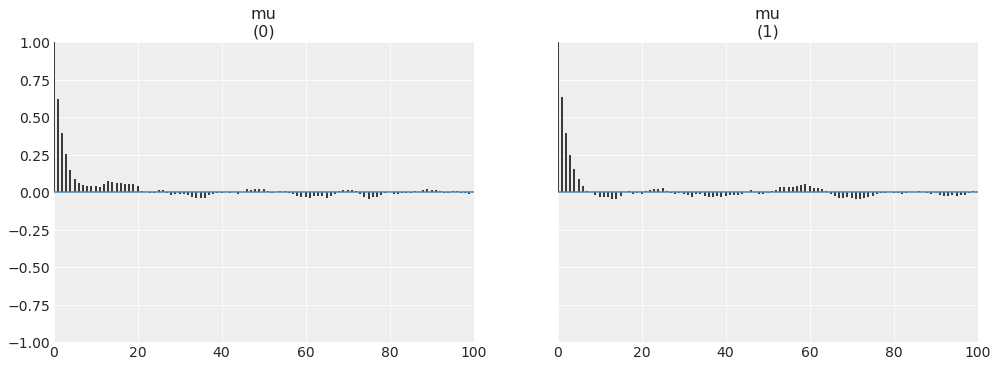

In [14]:
# Attempt to use pymc3 to estimate mean of the distribution
with pm.Model() as model:
    mu = pm.Uniform("mu")
    y = pm.Normal("y", mu=mu, sd=SD, observed=obs)
    step = pm.Metropolis()
    trace = pm.sample(5000, step, chains=2)
    
az.plot_autocorr(trace)

By reparamatrizing the model, specifically changing the prior and increasing the numbers of draws, a much more desirable autocorrelation plot is obtained, showing a sharper decrease in the magnitude of correlation with long term values centered at roughly 0. 

## Other strategies for poor autocorrelation
Thinning is an additional strategy that has been proposed for working with highly autocorrelated models. Thinning is a method where every only every nth sample from the MCMC chain is preserved, and the rest are ignored. The motivation behind this idea is that the `n` and `n+1` samples in an MCMC chain are more likely to be correlated than samples `n` and `n+10`.

However Kruschke reccomends against autothinning, reasoning that reparamatrization is more efficient than autothinning. A link to a full discussion can be found in the references.

## References
[How Autocorrelation Works](https://www.youtube.com/watch?v=ZjaBn93YPWo) - Brandon Rohrer  
[Traceplots and autocorrelation](https://www.coursera.org/lecture/mcmc-bayesian-statistics/trace-plots-autocorrelation-oqvff?authMode=login) - Matthew Heiner  
[Convergence Diagnostics for Markov Chain Monte Carlo](http://astrostatistics.psu.edu/RLectures/diagnosticsMCMC.pdf) - Eric B Ford  
[AutoCorrelation](http://doingbayesiandataanalysis.blogspot.com/2011/11/thinning-to-reduce-autocorrelation.html) - NIST